In [450]:
import numpy as np
from numpy import random
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import qiskit.quantum_info
from qiskit.visualization import plot_histogram, plot_state_city
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister
from collections import Counter
from matplotlib import font_manager
from qiskit import QuantumCircuit, transpile

In [451]:
def makeError(phi: float, disp: float) -> float:
  random_number = np.random.normal(0, (disp*disp), None)
  #print(random_number)
  return (phi + random_number)

In [452]:
def QFT(circuit: QuantumCircuit, start: int, n: int, disp: float = 0) -> QuantumCircuit:
  for i in range(n - 1, start - 1, -1):
    circuit.h(i)
    for j in range(i - 1, start - 1, -1):
      phase = np.pi / pow(2, i - j)
      phase = makeError(phase, disp)
      circuit.cp(phase, j, i)
  return circuit

In [453]:
def IQFT(circuit: QuantumCircuit, start: int, n: int, disp: float = 0) -> QuantumCircuit:
  for i in range(start, n, 1):
    for j in range(start, i, 1):
      phase = -np.pi / pow(2, i - j)
      phase = makeError(phase, disp)
      circuit.cp(phase, j, i)
    circuit.h(i)
  return circuit

In [454]:
def copy_qubit(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:

  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)
  return circuit

In [455]:
def qubit_flip_correction(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:
  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)

  circuit.ccx(an2, an1, qubit)
  return circuit

In [456]:
def QFT_adder_const(
    circuit: QuantumCircuit, 
    const: int, 
    b_start: int, 
    n:int, 
    inverse: bool = False, 
    disp: float = 0
) -> QuantumCircuit:
    sign = 1 if not inverse else -1
    for j in range(n):
      target_qbit = b_start + j
      phase = sign * np.pi * const / (1 << j)
      phase = makeError(phase, disp)
      circuit.p(phase, target_qbit)
    return circuit





def QFT_adder_const_with_correction(circuit: QuantumCircuit, const: int, b_start: int, 
            n: int, inverse: bool, disp: float = 0) -> QuantumCircuit:
  new_qubits_count = 2 * circuit.num_qubits
  new_qr = QuantumRegister(new_qubits_count, 'ancilla')
  circuit.add_register(new_qr)
  circuit.barrier(label="copy")
  for i in range(0, n):
    circuit = copy_qubit(circuit, b_start + i, b_start + i + n, b_start + i + 2*n)
  
  
  for i in range(3):
    circuit.barrier(label="qft")
    circuit = QFT(circuit, i*n, i*n+ n, disp)
    circuit.barrier(label="sum")
    circuit = QFT_adder_const(circuit, const, i * n, n, inverse, disp)
    circuit.barrier(label="iqft")
    circuit = IQFT(circuit, i*n, i*n + n, disp)
  

  circuit.barrier(label="correction")
  for i in range(0, n):
    circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + n, b_start + i + 2 * n)
  return circuit



def QFT_adder_const_Controlled(
    circuit: QuantumCircuit, 
    controls: list[int],
    const: int,
    b_start: int, 
    n: int,
    inverse: bool = False,
    disp: float = 0
) -> QuantumCircuit:
    sign = 1 if not inverse else -1
    for j in range(n):
        target_qbit = b_start + j
        phase = sign * np.pi * const / (1 << j)
        phase = makeError(phase, disp)
        phase_gate = PhaseGate(phase).control(len(controls))
        circuit.append(phase_gate, controls + [target_qbit])
    return circuit

def QFT_adder_const_Controlled_with_correction(
    circuit: QuantumCircuit, 
    controls: list[int],
    const: int,
    b_start: int, 
    n: int,
    inverse: bool = False,
    disp: float = 0
) -> QuantumCircuit:
    new_qubits_count = 2 * (circuit.num_qubits - 2)
    new_qr = QuantumRegister(new_qubits_count, 'ancilla')
    circuit.add_register(new_qr)
    circuit.barrier(label="copy")
    for i in range(0, n):
      circuit = copy_qubit(circuit, b_start + i, b_start + i + n, b_start + i + 2*n)
  
  
    for i in range(3):
      circuit.barrier(label="qft")
      circuit = QFT(circuit, b_start + i*n, b_start + i*n + n, disp)
      circuit.barrier(label="sum")
      circuit = QFT_adder_const_Controlled(circuit, controls, const,  b_start + i*n, n, inverse, disp)
      circuit.barrier(label="iqft")
      circuit = IQFT(circuit, b_start + i*n, b_start + i*n + n, disp)
    circuit.barrier(label="correction")
    for i in range(0, n):
      circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + n, b_start + i + 2 * n)
    return circuit



def QFT_adder_const_mod_N(
    circuit: QuantumCircuit, 
    const: int,      # Классическое значение A
    N: int,            # Модуль N
    b_start: int,      # Начальный индекс регистра B (n+1 кубит)
    n: int,       # Размер регистра B (n+1)
    ancilla: int,      # Индекс ансиллы (1 кубит)
    control_1: int,    # Индекс c1
    control_2: int,    # Индекс c2
    disp: float = 0
) -> QuantumCircuit:
    
    msb_qubit = b_start + n - 1
    circuit.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, False, disp)
    circuit.barrier()
    circuit = QFT_adder_const(circuit, N, b_start, n, True, disp)
    circuit.barrier()
    circuit = IQFT(circuit, b_start, b_start + n, disp) 
    circuit.barrier()
    circuit.cx(msb_qubit, ancilla)
    circuit.barrier()
    circuit = QFT(circuit, b_start, b_start + n, disp)
    circuit.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [ancilla], 
                                         N, b_start, n, False, disp)
    circuit.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, True, disp)
    circuit.barrier()
    circuit = IQFT(circuit, b_start, b_start + n, disp) 
    circuit.barrier()
    circuit.x(msb_qubit) 
    circuit.cx(msb_qubit, ancilla)
    circuit.x(msb_qubit) 
    circuit.barrier()
    circuit = QFT(circuit, b_start, b_start + n, disp)
    circuit.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, False, disp)
    circuit.barrier()
    return circuit



# def QFT_adder_const_mod_N_with_correction(
#     circuit: QuantumCircuit, 
#     const: int,      # Классическое значение A
#     N: int,            # Модуль N
#     b_start: int,      # Начальный индекс регистра B (n+1 кубит)
#     n: int,       # Размер регистра B (n+1)
#     ancilla: int,      # Индекс ансиллы (1 кубит)
#     control_1: int,    # Индекс c1
#     control_2: int,    # Индекс c2
#     disp: float = 0
# ) -> QuantumCircuit:
#     new_qubits_count = 2 * (circuit.num_qubits - 3)
#     new_qr = QuantumRegister(new_qubits_count, 'ancilla')
#     circuit.add_register(new_qr)
#     circuit.barrier(label="copy")
#     for i in range(0, n):
#       circuit = copy_qubit(circuit, b_start + i, b_start + i + n + 1, b_start + i + 2*n + 1)
  
  
#     for i in range(3):
#       circuit.barrier(label="qft")
#       circuit = QFT(circuit, b_start + i*n, b_start + i*n + n, disp)
#       circuit.barrier(label="sum")
#       circuit = QFT_adder_const_Controlled(circuit, controls, const,  b_start + i*n, n, inverse, disp)
#       circuit.barrier(label="iqft")
#       circuit = IQFT(circuit, b_start + i*n, b_start + i*n + n, disp)
#     circuit.barrier(label="correction")
#     for i in range(0, n):
#       circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + n, b_start + i + 2 * n)
#     return circuit



def CMUL(
    circuit: QuantumCircuit, 
    control_qubit: int, 
    x_start: int, 
    b_start: int, 
    n :int, 
    a:int, 
    N: int,
    ancilla: int, 
    disp: float):


    for i in range(n):
       argument = pow(2, i)*a
       circuit = QFT_adder_const_mod_N(circuit, argument, N, b_start, n, ancilla, control_qubit, x_start+i, disp)
      
    return circuit


def CMUL_with_correction(
    circuit: QuantumCircuit, 
    control_qubit: int, 
    x_start: int, 
    b_start: int, 
    n :int, 
    a:int, 
    N: int,
    ancilla: int, 
    disp: float):

    new_qubits_count = 2 * (circuit.num_qubits - 1 - n)
    new_qr = QuantumRegister(new_qubits_count, 'ancilla')
    circuit.add_register(new_qr)
    circuit.barrier(label="copy")
    for i in range(0, n):
      circuit = copy_qubit(circuit, b_start + i, b_start + i + (n + 1), b_start + i + 2*(n + 1))
  
  
    for i in range(3):
      circuit.barrier(label="qft")
      circuit = QFT(circuit, b_start + i*(n + 1), b_start + i*(n+1) + n, disp)
      circuit.barrier(label="mul")
      circuit = CMUL(circuit, control_qubit, x_start, b_start + i*(n + 1), n, a, N, b_start + i*(n + 1) + n, disp)
      circuit.barrier(label="iqft")
      circuit = IQFT(circuit, b_start + i*(n + 1), b_start + i*(n+1) + n, disp)
    circuit.barrier(label="correction")
    for i in range(0, n):
      circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + (n + 1), b_start + i + 2*(n + 1))
    return circuit
    



Тестирование обычного сумматора без корреции

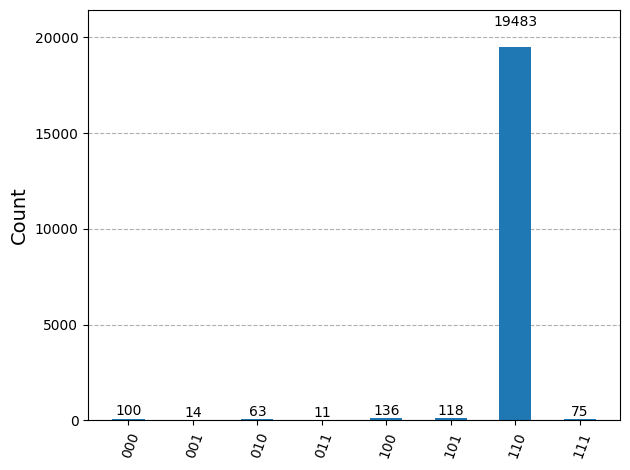

In [457]:
b_len = 3
q = QuantumCircuit(b_len)
q.x(0)
q = QFT(circuit=q, start=0, n=b_len, disp=0)
q = QFT_adder_const(circuit=q, const=5, b_start=0, n=b_len, inverse=False, disp=0.5)
q = IQFT(circuit=q, start=0, n=b_len, disp=0)



# q.add_register(ClassicalRegister(num_qbit))
# q.measure(range(num_qbit), range(num_qbit))
q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Тестирование обычного сумматора с коррекцией

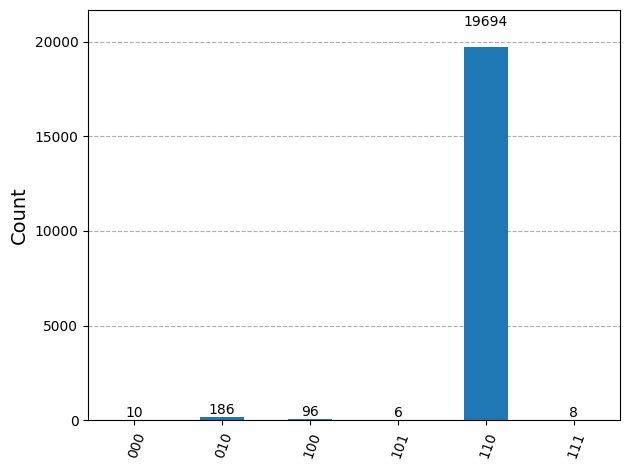

In [458]:
b_len = 3
q = QuantumCircuit(b_len)
q.x(0)
q = QFT_adder_const_with_correction(circuit=q, const=5, b_start=0, n=b_len, inverse=False, disp=0.5)

q.add_register(ClassicalRegister(b_len))
q.measure(range(b_len), range(b_len))
#q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Тестирование контрольного сумматора без коррекции

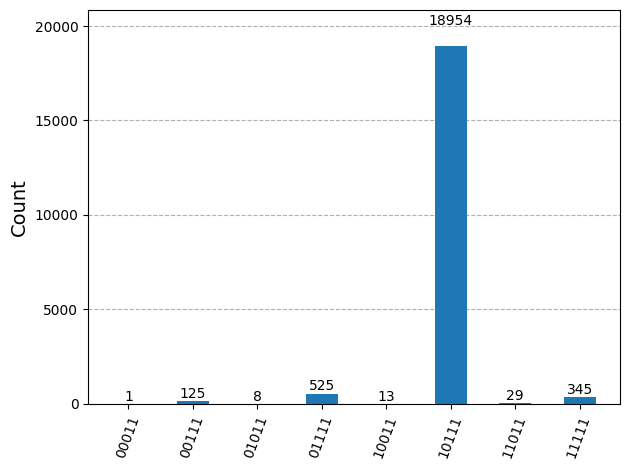

In [459]:
b_len = 3
num_qbit = 2 + b_len
q = QuantumCircuit(num_qbit)
q.x(0)
q.x(1)
q.x(3)
q = QFT(circuit=q, start=2, n=2 + b_len, disp=0)
q = QFT_adder_const_Controlled(circuit=q, controls=[0, 1], const=3, b_start=2, n=b_len, inverse=False, disp=0.5)
q = IQFT(circuit=q, start=2, n=2+ b_len, disp=0)



# q.add_register(ClassicalRegister(num_qbit))
# q.measure(range(num_qbit), range(num_qbit))
q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Тестирование контрольного сумматора с коррекцией 

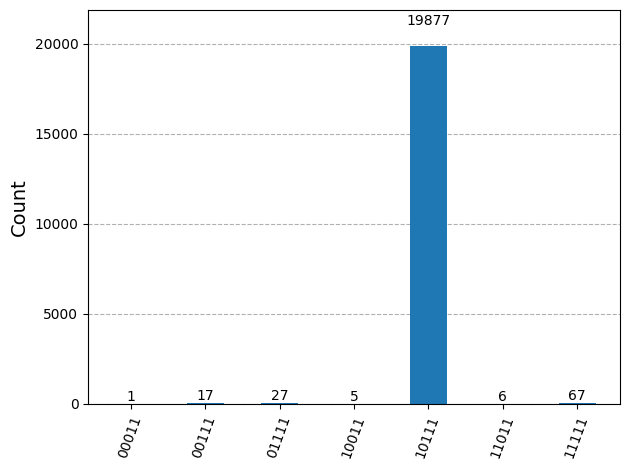

In [460]:
b_len = 3
num_qbit = 2 + b_len
q = QuantumCircuit(num_qbit)
q.x(0)
q.x(1)
q.x(3)
q = QFT_adder_const_Controlled_with_correction(circuit=q, controls=[0, 1], const=3, b_start=2, n=b_len, inverse=False, disp=0.5)


q.add_register(ClassicalRegister(num_qbit))
q.measure(range(num_qbit), range(num_qbit))
#q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Тестирование модульного сумматора без коррекции
$1 < a <= N-1$


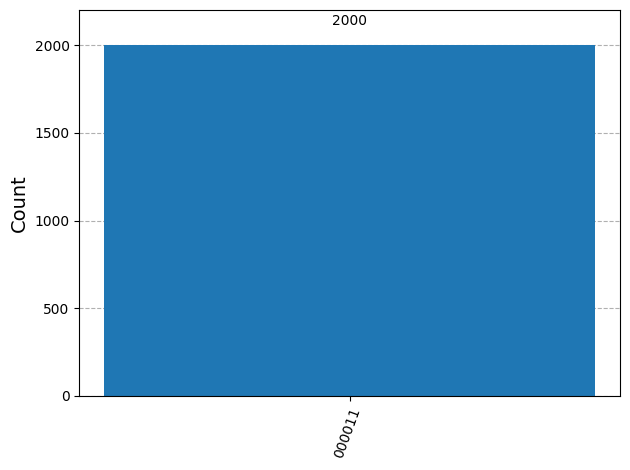

In [461]:
b_len = 3
num_qbit = 2 + b_len + 1
q = QuantumCircuit(num_qbit)
q.x(0)
q.x(1)

q.x(2)

q = QFT(circuit=q, start=2, n=2 + b_len, disp=0)
q = QFT_adder_const_mod_N(circuit=q, const=4, N=5, b_start=2, n=b_len, ancilla=num_qbit - 1, control_1=0, control_2=1, disp=0)
q = IQFT(circuit=q, start=2, n=2 + b_len, disp=0)

q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=2000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)


Тестирование умножения без коррекции

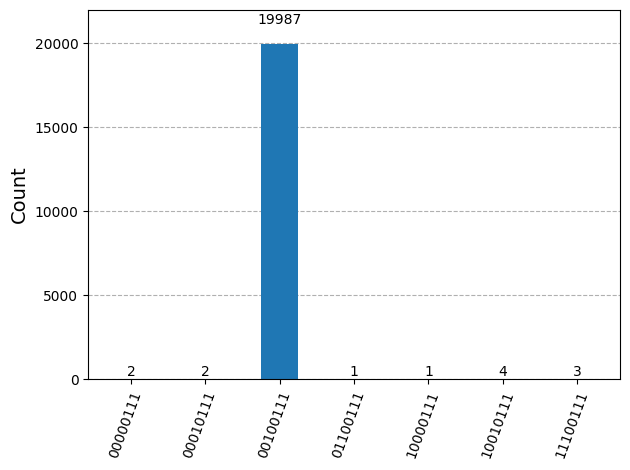

In [462]:
x_b_len = 3
num_qbit = 1 + x_b_len + x_b_len + 1
q = QuantumCircuit(num_qbit)

q.x(0)
q.x(2)
q.x(1)
q = QFT(circuit=q, start=1+x_b_len, n=1 + x_b_len + x_b_len, disp=0.1)
q = CMUL(circuit=q, control_qubit=0, x_start=1, b_start=1+x_b_len, n=x_b_len, a=2, N=4, ancilla=num_qbit-1, disp=0.1)
q = IQFT(circuit=q, start=1+x_b_len, n=1 + x_b_len + x_b_len, disp=0.1)

q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Тестирование умножения с коррекцией

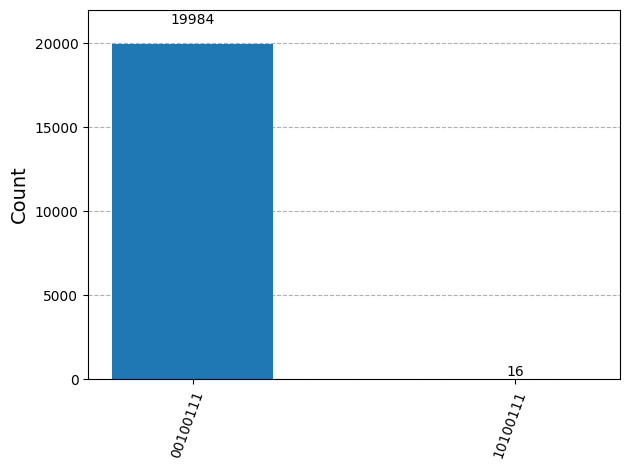

In [463]:
x_b_len = 3
num_qbit = 1 + x_b_len + x_b_len + 1
q = QuantumCircuit(num_qbit)

q.x(0)
q.x(2)
q.x(1)
#q.x(4)
q = CMUL_with_correction(circuit=q, control_qubit=0, x_start=1, b_start=1+x_b_len, n=x_b_len, a=2, N=4, ancilla=num_qbit-1, disp=0.1)

q.add_register(ClassicalRegister(num_qbit))
q.measure(range(num_qbit), range(num_qbit))
#q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=20000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

Эксперименты над умножением. Гистограммы

In [483]:
def Experiment(backend, circuit: QuantumCircuit, a: int, N: int, count_of_mes: int, correction: bool, 
               disp: float = 0) -> dict:

    num_qbit = circuit.num_qubits
    x_b_len = (num_qbit-2) // 2
    final_counts = Counter()
    for n in range(0, count_of_mes):
        q = circuit.copy()
        if (not correction):
            q = QFT(circuit=q, start=1+x_b_len, n=1 + x_b_len + x_b_len, disp=disp)
            q = CMUL(q, 0, 1, 1+x_b_len, x_b_len, a, N, num_qbit-1, disp)
            q = IQFT(circuit=q, start=1+x_b_len, n=1 + x_b_len + x_b_len, disp=disp)
        else:
            q = CMUL_with_correction(q, 0, 1, 1+x_b_len, x_b_len, a, N, num_qbit-1, disp)
        q.add_register(ClassicalRegister(circuit.num_qubits))
        q.measure(range(circuit.num_qubits), range(circuit.num_qubits))
        result = backend.run(q, shots = 1).result()
        current_counts = result.get_counts()
        final_counts += Counter(current_counts)
    
    return dict(final_counts)

{'00100111': 9127, '11100111': 185, '01010111': 10, '01100111': 126, '00000111': 89, '10100111': 147, '01110111': 6, '00110111': 87, '11110111': 11, '00010111': 61, '01000111': 41, '10000111': 49, '10010111': 38, '11010111': 2, '11000111': 13, '10110111': 8}


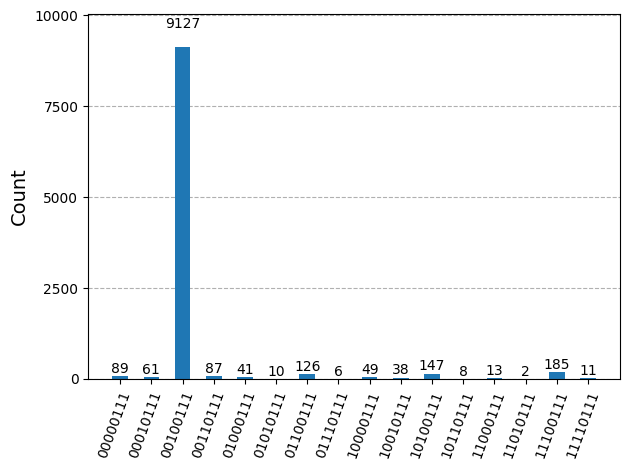

In [ ]:
backend = AerSimulator()
x_b_len = 3
num_qbit = 1 + x_b_len + x_b_len + 1
q = QuantumCircuit(num_qbit)

q.x(0)
q.x(2)
q.x(1)


result_dict = Experiment(backend, q, 2, 4, 10000, True, 0.3)
print(result_dict)
plot_histogram(result_dict)
# q.draw("mpl")